In [69]:
import _init_paths
from PIL import Image
import numpy as np
import cv2
import random
from mmcv import Config

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from dall_e  import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown

from vcl.models.trackers import *
from vcl.models.vqvae import *
from vcl.models import MODELS
from vcl.utils import *
from mmcv.runner import get_dist_info, init_dist, load_checkpoint

import matplotlib.pyplot as plt
%matplotlib inline

target_image_size = 256
save_path = '/homr/lr/reports/12-2/new'

samples = []
with open('/home/lr/dataset/YouTube-VOS/2018/train/test_records.txt', 'r') as f:
    for line in f.readlines():
        name, frame_idx, pixel_idx = line.strip('\n').split()
        samples.append([name, int(frame_idx), int(pixel_idx)])

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

def load_anno():
    video_dir = '/home/lr/dataset/YouTube-VOS/2018/train/JPEGImages'
    list_path = '/home/lr/dataset/YouTube-VOS/2018/train/youtube2018_train_list.txt'

    samples = []

    with open(list_path, 'r') as f:
        for idx, line in enumerate(f.readlines()):
            sample = dict()
            vname, num_frames = line.strip('\n').split()
            sample['frames_path'] = sorted(glob.glob(osp.join(video_dir, vname, '*.jpg')))
            sample['num_frames'] = int(num_frames)
            samples.append(sample)
    return samples



def preprocess_(img):
    
    mean=np.array([123.675, 116.28, 103.53])
    std=np.array([58.395, 57.12, 57.375])
    
    # resize
    img = img.astype(np.float32)
    
    mmcv.imnormalize_(img, mean, std, False)
    
    out = torch.from_numpy(img).unsqueeze(0).permute(0, 3, 1, 2)
    return out


In [70]:
# sample frame
import os.path as osp
import glob


# sample_video_idx = 92
sample_video_idx = random.randint(0, 300)
sample_video_idx2 = random.randint(0, 300)

print(sample_video_idx, sample_video_idx2)

sample = {}
sample['frames_path'] = sorted(glob.glob(osp.join('/home/lr/dataset/YouTube-VOS/2018/train/JPEGImages', samples[sample_video_idx][0], '*.jpg')))
sample['frames_path2'] = sorted(glob.glob(osp.join('/home/lr/dataset/YouTube-VOS/2018/train/JPEGImages', samples[sample_video_idx2][0], '*.jpg')))


frame_idx = samples[sample_video_idx][1]
sample_idx = samples[sample_video_idx][2]


frame1 = cv2.imread(sample['frames_path'][frame_idx])[:,:,::-1]
frame2 = cv2.imread(sample['frames_path2'][frame_idx+1])[:,:,::-1]
frame1 = cv2.resize(frame1, (256,256))
frame2 = cv2.resize(frame2, (256,256))


x1 = preprocess_(frame1).cuda()
x2 = preprocess_(frame2).cuda()

261 254


2022-01-12 20:53:53,574 - vcl - INFO - load th pretrained VQVAE successfully


Use load_from_local loader
Use load_from_local loader


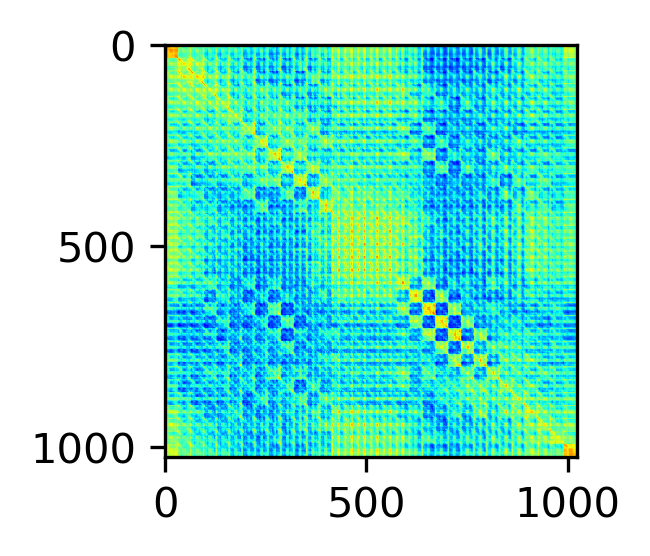

In [71]:
cfg = Config.fromfile('/home/lr/project/vcl/configs/test/vqvae_mlm_orivq_viz.py')

model = build_model(cfg.model, train_cfg=None, test_cfg=None).cuda()
model.eval()
_ = load_checkpoint(model, '/home/lr/expdir/VCL/group_vqvae_tracker/vqvae_mlm_d4_nemd2048_byol_dyt_nl_l5_fc_orivq_withbbox_random_v2_longterm/epoch_3200.pth')

f1 = model.backbone(x1).flatten(2).permute(0,2,1)[0]
f2 = model.backbone(x2).flatten(2).permute(0,2,1)[0]


att = torch.einsum('ic,jc->ij', [f1, f2])

att = att.cpu().detach().numpy().astype(np.uint8)

plt.rcParams['figure.dpi'] = 300
plt.figure()
plt.subplot(2,2,1)
plt.imshow(att, cmap=plt.get_cmap('jet'))

2022-01-12 20:53:54,642 - vcl - INFO - load th pretrained VQVAE successfully
2022-01-12 20:53:54,728 - vcl - INFO - load pretrained model successfully


Use load_from_local loader
Use load_from_local loader
The model and loaded state dict do not match exactly

unexpected key in source state_dict: quantize.embed, quantize.cluster_size, quantize.embed_avg, quantize_conv.weight, quantize_conv.bias, head.projection_fcs.0.weight, head.projection_fcs.0.bias, head.projection_fcs.1.weight, head.projection_fcs.1.bias, head.projection_fcs.1.running_mean, head.projection_fcs.1.running_var, head.projection_fcs.1.num_batches_tracked, head.projection_fcs.3.weight, head.projection_fcs.3.bias, head.projection_fcs.4.weight, head.projection_fcs.4.bias, head.projection_fcs.4.running_mean, head.projection_fcs.4.running_var, head.projection_fcs.4.num_batches_tracked, head.projection_fcs.6.weight, head.projection_fcs.6.bias, head.projection_fcs.7.weight, head.projection_fcs.7.bias, head.projection_fcs.7.running_mean, head.projection_fcs.7.running_var, head.projection_fcs.7.num_batches_tracked, head.predictor_fcs.0.weight, head.predictor_fcs.0.bias, head.pre

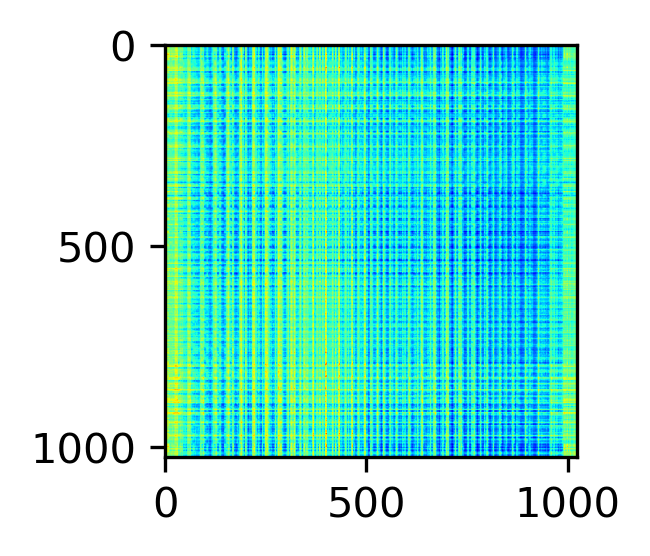

In [72]:
cfg = Config.fromfile('/home/lr/project/vcl/configs/train/local/vqvae_mlm_d4_nemd2048_byol_dyt_nl_l2_fc_orivq_withbbox_random_v2_5.py')

model = build_model(cfg.model, train_cfg=None, test_cfg=None).cuda()
model.eval()
_ = load_checkpoint(model, '/home/lr/expdir/VCL/group_vqvae_tracker/vqvae_mlm_d4_nemd2048_byol_dyt_nl_l2_fc_orivq_withbbox_random_v2_2/epoch_3200.pth')

f1 = model.backbone(x1).flatten(2).permute(0,2,1)[0]
f2 = model.backbone(x2).flatten(2).permute(0,2,1)[0]


att = torch.einsum('ic,jc->ij', [f1, f2])

att = att.cpu().detach().numpy().astype(np.uint8)

plt.rcParams['figure.dpi'] = 300
plt.figure()
plt.subplot(2,2,1)
plt.imshow(att, cmap=plt.get_cmap('jet'))